# Import libraries and setup

In [1]:
# Import libraries we may need
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import scanpy.external as sce
import wget
import yaml
import wget
import astir
import dill
import umap
reducer = umap.UMAP()

#My module for importing IMC data into AnnData format
import mikeimc as mimc

In [2]:
# Set up output figure settings
plt.rcParams['figure.figsize']=(64,64) #rescale figures, increase sizehere

# Set up scanpy settings
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, dpi_save=300) #Increase DPI for better resolution figures
#sc.logging.print_versions()

# Save / restore environemnt
Use these functions to either save or load the environmental variables, otherwise you will lose all the objects between opening/closing Jupyter sessions!

In [3]:
#load the session
dill.load_session('DC_notebook_env_iteration3_ASTIR.db')

In [13]:
#save the session
dill.dump_session('DC_notebook_env_iteration3_ASTIR.db')

# Importing data and setup

In [ ]:
#This approach of generating adata is different from the approach below and it uses different input files.

from importlib import reload
mimc = reload(mimc)

adata, df_misc = mimc.celltable_to_adata(column_properties='mikeimc_approach/columns.csv', #Contents define how the columns in the cell table should be handled
                                                cell_table='mikeimc_approach/cells.csv', #The full cell table as exported by whatever cell segmentation pipeline
                                                dictionary='mikeimc_approach/dictionary.csv', #If this is specified, it will add extra observations based upon the ROI, e.g. what group/patient/treatment it came from
                                                marker_normalisation='99th', #Marker normalisation, by default will be None
                                                misc_table=True) #Whether or not a second dataframe of 'misc' findings will be imported

In [4]:
adata

AnnData object with n_obs × n_vars = 249163 × 45
    obs: 'Master_Index', 'ROI', 'Case', 'Type', 'X_loc', 'Y_loc', 'HEClass'
    obsm: 'spatial'

In [ ]:
all_markers = adata.var_names.tolist()
print ('List of all markers found:')
print (all_markers,end= '\n\n')

#skipe this step: Change this with a list of the markers you'd like to be remove entirely from the dataset, e.g. DNA stains
markers_to_remove = ['Solidity']
markers_to_remove2 = ['DNA1', 'DNA2', 'Area','Extent', 'Eccentricity','NN', 'Solidity']

#Remove markers from list
markers_limited = [m for m in all_markers if m not in markers_to_remove]
markers_limited2 = [m for m in all_markers if m not in markers_to_remove2]

#print ('List of all markers with removed items:')
print (markers_limited)
print (markers_limited2)

In [ ]:
#Filter to only markers specified above
adata_filtered = adata[:,markers_limited]
#The .copy() makes a completely seperate copy
adata_subset = adata_filtered.copy()
#This code further filters the data by removing cells from C10, C31 ROIs and C21_ROI3
adata_subset = adata_filtered[~adata_filtered.obs['ROI'].isin(['C10_ROI1','C10_ROI2','C10_ROI3', 'C10_ROI4', 'C21_ROI3', 'C31_ROI1', 'C31_ROI2', 'C31_ROI3', 'C31_ROI4']),:].copy()

adata_filtered2 = adata[:,markers_limited2]
#The .copy() makes a completely seperate copy
adata_subset2 = adata_filtered2.copy()
#This code further filters the data by removing cells from C10, C31 ROIs and C21_ROI3
adata_subset2 = adata_filtered2[~adata_filtered2.obs['ROI'].isin(['C10_ROI1','C10_ROI2','C10_ROI3', 'C10_ROI4', 'C21_ROI3', 'C31_ROI1', 'C31_ROI2', 'C31_ROI3', 'C31_ROI4']),:].copy()

adata_subset2.var_names

# QC Checking data

In [ ]:
sc.pl.matrixplot(adata_subset2, adata_subset2.var_names, groupby='ROI', save='_QC_matrixplot_ROIs.pdf')

#Number of cells per ROI
print(adata_subset2.obs['ROI'].value_counts())

... storing 'cell_type' as categorical
... storing 'hierarchy' as categorical


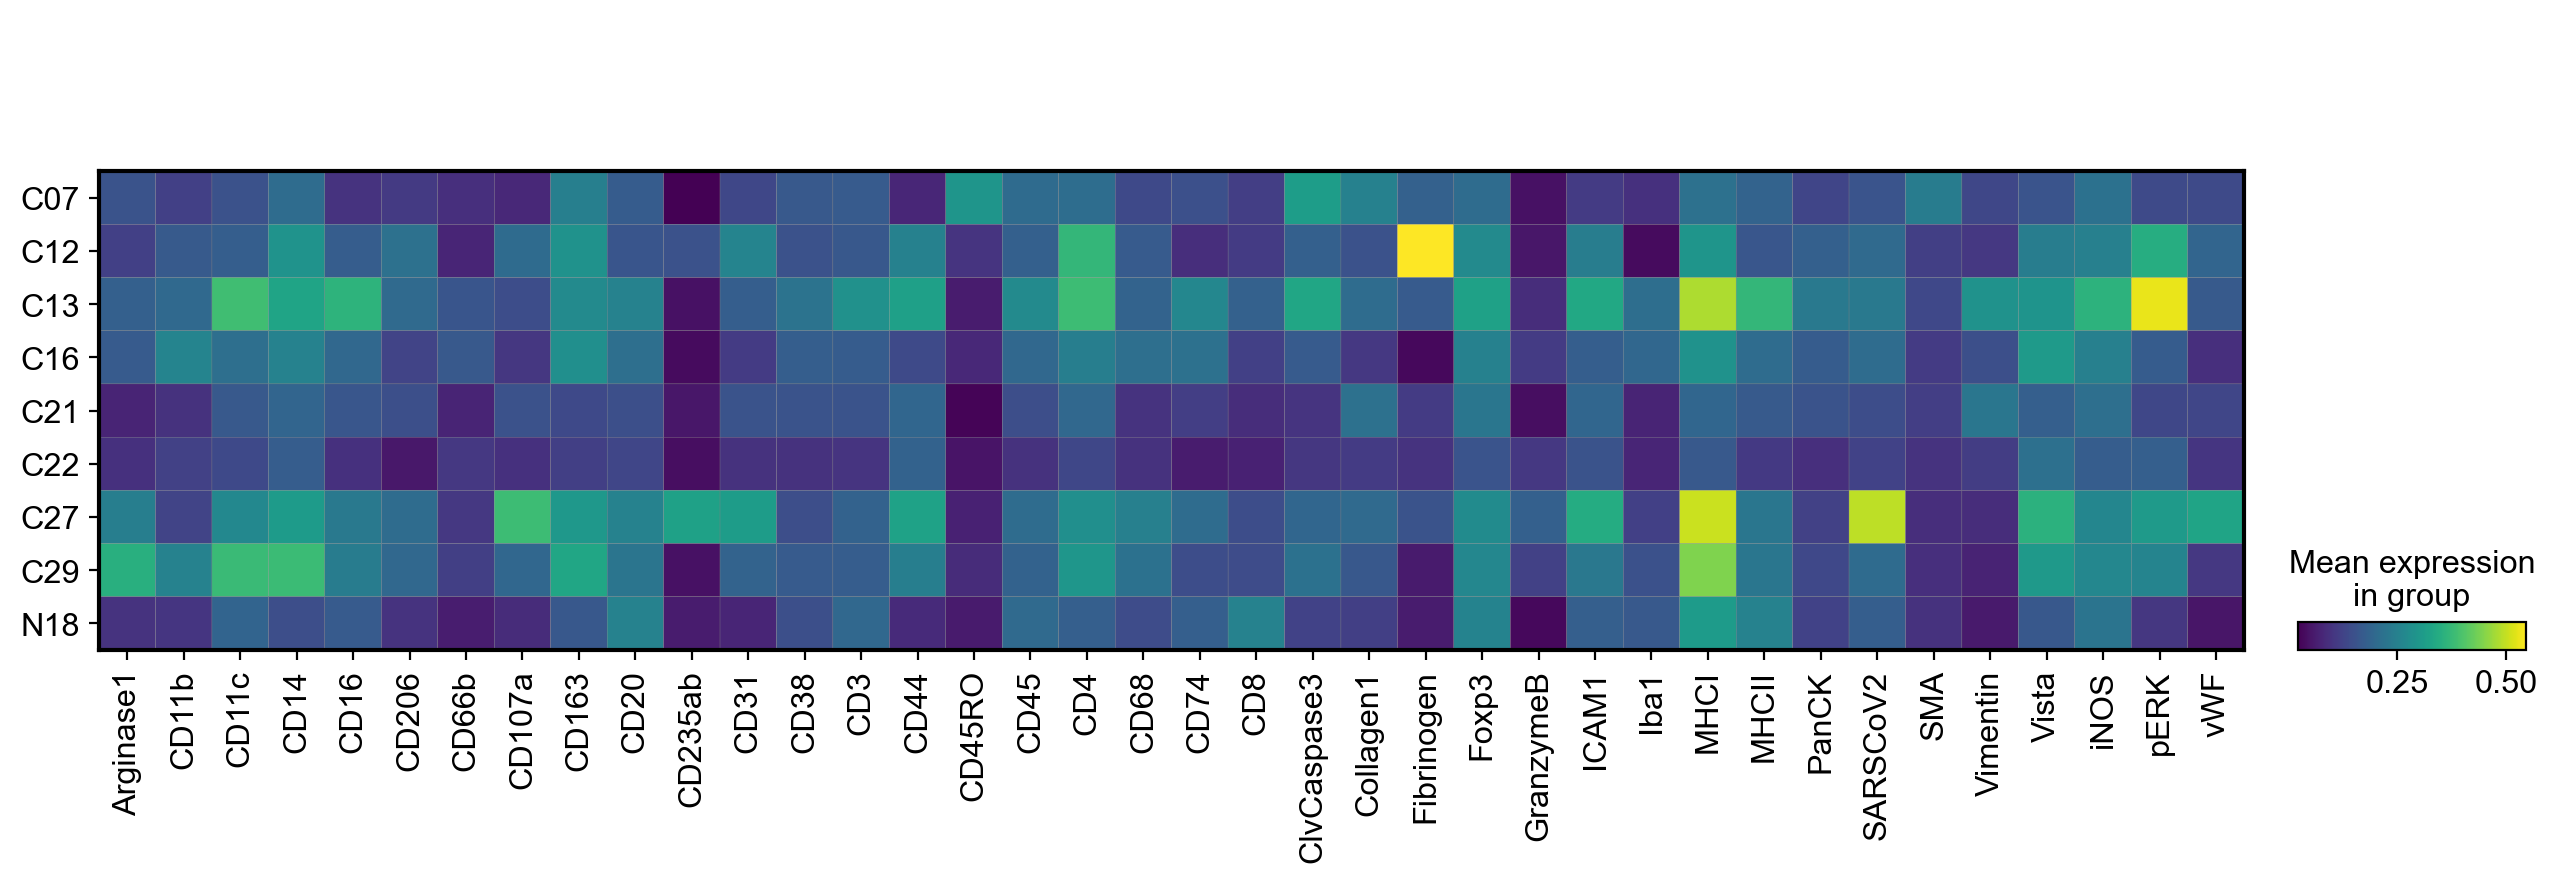

C13    33629
C16    31941
C07    25471
N18    17984
C12    17374
C27    16526
C22    16172
C29    16132
C21    14192
Name: Case, dtype: int64


In [7]:
sc.pl.matrixplot(adata_subset2, adata_subset2.var_names, groupby='Case')

#Number of cells per ROI
print (adata_subset2.obs['Case'].value_counts())

# PCA analyses

In [ ]:
#Show those markers that yield the highest fraction of counts in each single cell, across all cells.\
sc.pl.highest_expr_genes(adata_subset2, n_top=20, )

#Identify highly-variable markers:
sc.pp.highly_variable_genes(adata_subset2, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_subset2)    

In [ ]:
#Calculate PCA - this must be done first
sc.tl.pca(adata_subset2, svd_solver='arpack')

#Inspect the contribution of single PCs to the total variance in the data. 
#This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells,
#e.g. used in the clustering function 
sc.pl.pca_variance_ratio(adata_subset2, log=False, save='PCA_iteration2.pdf')

#Visualise all PCAs
sc.pl.pca(adata_subset2, color='Type', components = ['1,2', '3,4', '5,6', '7,8'], ncols=2, size=0.5, save='PCA_iteration2_v2.pdf')

In [ ]:
#Inspect the contribution of single PCs to the total variance in the data. 
#This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells,
#e.g. used in the clustering function 
sc.pl.pca_variance_ratio(adata_subset2, log=False)

#Visualise all PCAs
sc.pl.pca(adata_subset2, color='Type', components = ['1,2', '3,4', '5,6', '7,8'], ncols=2, size=0.5, save='_iteration2_v3.pdf')

In [ ]:
#Plot loadings of PCA to figure out what is contributing to variability
sc.pl.pca_loadings(adata_subset2, components=[1,2,3,4,5,6,7,8], save = '_iteration2_v4.pdf')

Marker selection

Filtering anndata

# Supervised cell type identification using Astir

This uses Astir (https://github.com/camlab-bioml/astir) to do 'semi-supervised' cell identification using a neural network. You specify the populations and markers in hte 'markers.yml' file - see the Astir documentation for full details

Import markers file and data file

In [ ]:
# Read in the YAML file with a list of the expected marker pairs
with open(r'markers.yml') as file:
  cell_types = yaml.load(file, Loader=yaml.FullLoader)

#View the contents of the YML file
!head markers.yml
print(cell_types['cell_types'])

In [ ]:
adata_subset.write(filename='adata_subset_iteration3_astir')
adata_subset2.write(filename='adata_subset2_iteration3_astir')

import os
import warnings
from typing import Any

import anndata
import loompy
import matplotlib.cbook
import numpy as np
import pandas as pd
import torch
import yaml
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from astir.data import from_anndata_yaml
#the name of the anndata file below has to be as saved above!!

ast = from_anndata_yaml("adata_subset_iteration3_astir", "markers.yml", batch_name=None)
ast

ast2 = from_anndata_yaml("adata_subset2_iteration3_astir", "markers.yml", batch_name=None)
ast2

Set training parameters

I've left these all as the default for now

In [ ]:
# Create batch size proportional to the number of cells
N = ast2.get_type_dataset().get_exprs_df().shape[0]
batch_size = int(N/100)

# Number of training epochs
max_epochs = 1000

# Set learning rate
learning_rate = 2e-3

# Set initial epochs
initial_epochs = 3

In [ ]:
#Run the cell type identification
ast2.fit_type(max_epochs = max_epochs,
             batch_size = batch_size,
             learning_rate = learning_rate,
             n_init_epochs = initial_epochs)

Number of cells of each type found

In [ ]:
ast2.get_celltypes().value_counts()

In [ ]:
df = ast2.diagnostics_celltype().head(n=10)
df

In [ ]:
#plot the losses to assess convergence
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast2.get_type_losses())), ast2.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [ ]:
#get cell type assignment probabilities
assignments = ast2.get_celltype_probabilities()
assignments

In [19]:
assignments.to_csv("../assignments_probabilities.csv")

In [ ]:
sb.heatmap(assignments, annot=False, xticklabels=1, yticklabels=False)

In [ ]:
ast2.get_celltypes()

In [17]:
ast2.type_to_csv("../cell-types.csv")

Add hierarchy and cell type data to original Adata

In [ ]:
# Check that the hierarchy dictionary have been loaded correctly
ast2.get_hierarchy_dict()

In [ ]:
#Retrieve the table of probabilites
hierarchy_table =  ast2.assign_celltype_hierarchy(depth = 1)

cell_types = hierarchy_table.columns.tolist()

#This is  the threshold as above - probably best to keep the same!
threshold_for_classification = 0.5

#Start a new list that will store the hierarchy data
hierarchy = []

#This will work down each row and figure out which hierarchy type have the highest probability
for index, row in hierarchy_table.iterrows():
    row_values = row.values
    max_prob = np.max(row_values)
    
    if max_prob < threshold_for_classification:
        #If the cell doesn't fit into any category, return Unknown
        hierarchy.append('Other')
    else:
        #Add to the list the 
        hierarchy.append(cell_types[np.argmax(row_values)])

adata_subset2.obs["cell_type"] = ast2.get_celltypes(threshold=threshold_for_classification)['cell_type']
adata_subset2.obs["hierarchy"] = hierarchy

In [ ]:
adata_subset2

In [ ]:
#This code further filters the data by removing cells from C10, C31 ROIs and C21_ROI3

#The .copy() makes a completely seperate copy
adata_subset3 = adata_subset2.copy()
adata_subset3 = adata_subset3[~adata_subset3.obs['cell_type'].isin(['Other','Unknown']),:].copy()
adata_subset3


In [ ]:
#Plot a heatmap grouped by hierarchy
sc.pl.heatmap(adata_subset3, adata_subset3.var_names, groupby='hierarchy',vmax=0.75, swap_axes=True) #save='_ASTIR_hierarchy.pdf')

In [10]:
#stack bar code and extracting number of cells, distribution of each cluster per case or the cluster composition per case
#for number of cells - don't use normalize
#for distribution of each case per cluster - use normalize = "index"
#for cluster composition per case - use normalize = "columns"
tmp = pd.crosstab(adata_subset3.obs['cell_type'], adata_subset3.obs['ROI'], margins=True, margins_name='Total')

In [11]:
tmp

ROI,C07_ROI1,C07_ROI2,C07_ROI3,C07_ROI4,C12_ROI1,C12_ROI2,C12_ROI3,C12_ROI4,C13_ROI1,C13_ROI2,...,C27_ROI3,C27_ROI4,C29_ROI2,C29_ROI3,C29_ROI4,N18_ROI1,N18_ROI2,N18_ROI3,N18_ROI4,Total
cell_type,,,,,,,,,,,,,,,,,,,,,
CD4 cells,239,347,276,131,132,196,128,123,607,748,...,106,54,118,222,126,103,66,83,118,6547
CD8 cells,245,300,261,191,10,7,7,4,289,423,...,42,49,101,152,159,696,773,409,1196,7000
Endothelium,212,120,169,108,502,491,496,426,359,163,...,754,636,166,265,257,19,11,8,15,8042
Epithelial,320,181,272,144,354,453,481,279,915,191,...,18,41,55,128,98,141,273,148,73,8383
Fibroblast,781,1045,755,307,94,145,36,86,745,191,...,450,304,189,292,110,170,132,63,184,9372
Macrophage,437,546,541,247,693,713,631,515,2048,2919,...,929,697,1406,1392,1612,634,419,368,436,30158
Myofibroblast,750,527,751,359,54,24,48,50,451,155,...,8,26,29,53,37,18,73,72,7,5645
Neutrophil,211,388,174,200,62,79,69,51,517,856,...,92,48,254,216,239,57,42,9,67,9050
RBCs,2,4,6,22,243,135,189,103,8,11,...,1708,831,7,24,36,11,33,35,6,5132


In [12]:
compression_opts = dict(method='zip',
                         archive_name='Metaclusters_number_per_ROI.csv') 
tmp.to_csv('out.zip', index=False, compression=compression_opts)

In [ ]:
#Plot a heatmap grouped by cell types
sc.pl.heatmap(adata_subset3, adata_subset3.var_names, groupby='cell_type', vmax=0.75, swap_axes=True) #save='_ASTIR_celltype.pdf')

In [ ]:
#Plot a heatmap grouped by ASTIR
sc.pl.matrixplot(adata_subset3, adata_subset3.var_names, groupby='cell_type', swap_axes=False, cmap='magma', save='_ASTIR_celltype.pdf')

In [ ]:
#Plot heatmap
adata_subset4 = adata_subset3.copy()
sc.tl.dendrogram(adata_subset4, groupby = 'cell_type')
sc.pl.heatmap(adata_subset4, adata_subset4.var_names, groupby='cell_type', vmax=0.75, swap_axes=True,dendrogram=True, figsize=(16,8), save='_ASTIR_celltype_clustered.pdf')

In [ ]:
#scale data for heatmap
adata_subset4 = adata_subset3.copy()
sc.pp.scale(adata_subset4, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_subset4, groupby = 'cell_type')
sc.pl.heatmap(adata_subset4, adata_subset4.var_names, groupby='cell_type', figsize=(16,8), dendrogram=True, swap_axes=True, cmap='viridis', save='scaled_ASTIR_celltype_clustered.pdf')

In [ ]:
#Population distribution

from importlib import reload

mimc = reload(mimc)
mimc.pop_distribution(adata_subset3,'cell_type',['ROI','Case','Type'])

# Create new adatas for all cell types for unsupervised analyses

# Myeloid cells

In [ ]:
adata_myeloid = adata_subset3[adata_subset3.obs['hierarchy'].isin(['Myeloid'])].copy()
sc.pl.heatmap(adata_myeloid, adata_myeloid.var_names, groupby='cell_type', vmax=0.75, swap_axes=True, save='_ASTIR_myeloid.pdf')

In [ ]:
#Plot clustered heatmap
sc.tl.dendrogram(adata_myeloid, groupby = 'cell_type')
sc.pl.heatmap(adata_myeloid, adata_myeloid.var_names, groupby='cell_type', vmax=0.75, swap_axes=True,dendrogram=True, save='_ASTIR_myeloid_clustered.pdf')

In [ ]:
#Plot scaled heatmap
adata_myeloid_norm = adata_myeloid.copy()
sc.pp.scale(adata_myeloid_norm, max_value=2,  zero_center=True)
sc.pl.heatmap(adata_myeloid_norm, adata_myeloid_norm.var_names, groupby='cell_type', swap_axes=True, save='_scaled_ASTIR_myeloid.pdf')

# Lymphoid cells

In [ ]:
#Plot heatmap
adata_lymphoid = adata_subset3[adata_subset3.obs['hierarchy'].isin(['Lymphoid'])].copy()
sc.pl.heatmap(adata_lymphoid, adata_lymphoid.var_names, groupby='cell_type', vmax=0.75, swap_axes=True, save='_ASTIR_lymphoid.pdf')

In [ ]:
#Plot scaled heatmap
adata_lymphoid_norm = adata_lymphoid.copy()
sc.pp.scale(adata_lymphoid_norm, max_value=1.5,  zero_center=True)
sc.pl.heatmap(adata_lymphoid_norm, adata_lymphoid_norm.var_names, groupby='cell_type', swap_axes=True, save='_scaled_ASTIR_lymphoid.pdf')

# Vascular and Stromal cells

In [ ]:
adata_vascular = adata_subset3[adata_subset3.obs['hierarchy'].isin(['Vascular'])].copy()
sc.pl.heatmap(adata_vascular, adata_vascular.var_names, groupby='cell_type', vmax=0.75, swap_axes=True, save='_ASTIR_vascular.pdf')

adata_endothelium = adata_subset3[adata_subset3.obs['cell_type'].isin(['Endothelium'])].copy()
sc.pl.heatmap(adata_endothelium, adata_endothelium.var_names, groupby='cell_type', swap_axes=True, vmax=0.75, save='_ASTIR_endothelium.pdf')

adata_RBC = adata_subset3[adata_subset3.obs['cell_type'].isin(['RBCs'])].copy()
sc.pl.heatmap(adata_RBC, adata_RBC.var_names, groupby='cell_type', swap_axes=True, vmax=0.75, save='_ASTIR_RBC.pdf')

#Plot scaled heatmap
adata_vascular_norm = adata_vascular.copy()
sc.pp.scale(adata_vascular_norm, max_value=0.5,  zero_center=True)
sc.pl.heatmap(adata_vascular_norm, adata_vascular_norm.var_names, groupby='cell_type', swap_axes=True, save='_scaled_ASTIR_vascular.pdf')

In [ ]:
adata_stromal = adata_subset3[adata_subset3.obs['hierarchy'].isin(['Stromal'])].copy()
sc.pl.heatmap(adata_stromal, adata_stromal.var_names, groupby='cell_type', swap_axes=True, vmax=0.75, save='_ASTIR_stromal.pdf' )

adata_epithelial = adata_subset3[adata_subset3.obs['cell_type'].isin(['Epithelial'])].copy()
sc.pl.heatmap(adata_epithelial, adata_epithelial.var_names, groupby='cell_type', swap_axes=True, vmax=0.75, save='_ASTIR_epithelial.pdf')

adata_fibroblast = adata_subset3[adata_subset3.obs['cell_type'].isin(['Fibroblast', 'Myofibroblast'])].copy()
sc.pl.heatmap(adata_fibroblast, adata_fibroblast.var_names, groupby='cell_type', swap_axes=True, vmax=0.75, save='_ASTIR_fibroblast.pdf')

# Unsupervised analyses on cellular types - ASTIR output

# ASTIR - clustering analysis including functional markers

# Analysis of Myeloid cells

In [ ]:
#including functional markers
myeloid_markers2 = ['CD11b','CD11c','CD14','CD163','CD16','CD206','CD45','CD66b','CD68','Iba1', 'CD74','MHCII','MHCI','Vista', 
                   'iNOS', 'CD107a','GranzymeB', 'ClvCaspase3', 'SARSCoV2']
adata_myeloid_3 = adata_myeloid[:,myeloid_markers2].copy()

lymphoid_markers2 = ['CD3','CD4','CD8', 'CD20','CD38','CD74','MHCII','MHCI', 'Foxp3','CD107a','GranzymeB','ClvCaspase3','SARSCoV2']
adata_lymphoid_3 = adata_lymphoid[:,lymphoid_markers2].copy()

epithelial_markers2 = ['PanCK','CD74','MHCII','MHCI','CD107a','GranzymeB','ClvCaspase3','SARSCoV2']
adata_epithelial_3 = adata_epithelial[:,epithelial_markers2].copy()

fibroblast_markers2 = ['Collagen1','SMA', 'Fibrinogen','ClvCaspase3','SARSCoV2']
adata_fibroblast_3 = adata_fibroblast[:,fibroblast_markers2].copy()

endothelial_markers2 = ['CD31','ICAM1','vWF','CD74','MHCII','MHCI','CD107a','GranzymeB','SARSCoV2']
adata_endothelium_3 = adata_endothelium[:,endothelial_markers2].copy()

RBC_markers2 = ['CD235ab','SARSCoV2']
adata_RBC_3 = adata_RBC[:,RBC_markers2].copy()

In [ ]:
#Calculate neighbors
sc.pp.neighbors(adata_myeloid_3, n_neighbors=100)

#Calculate UMAP
sc.tl.umap(adata_myeloid_3)

In [ ]:
adata_myeloid_3

In [ ]:
#Plot UMAP
sc.pl.umap(adata_myeloid_3, color=['ROI'], save='_myeloid_ROI_v2.pdf')

In [ ]:
#Plot UMAP
sc.pl.umap(adata_myeloid_3, color=['Type'], save='_myeloid_Type_v2.pdf')

In [ ]:
#Plot UMAP for each marker
sc.pl.umap(adata_myeloid_3, color=adata_myeloid_3.var_names, save='_myeloid_Markers_v2.pdf')

In [ ]:
#Run PCA
sc.tl.pca(adata_myeloid_3)

#Calculate tSNE
sc.tl.tsne(adata_myeloid_3)

In [ ]:
#Plot tSNE 
sc.pl.tsne(adata_myeloid_3, color=['ROI'], save='_myeloid_ROI_v2.pdf')

In [ ]:
#Plot tSNE 
sc.pl.tsne(adata_myeloid_3, color=['Type'], save='_myeloid_cases_v2.pdf')

In [ ]:
#Plot tSNE for each marker
sc.pl.tsne(adata_myeloid_3, color=adata_myeloid_3.var_names, save='_myeloid_Markers_v2.pdf')

In [ ]:
#Run PhenoGraph
sce.tl.phenograph(adata_myeloid_3, clustering_algo="louvain", k=200, seed=1)

In [ ]:
#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_myeloid_3, color = "pheno_louvain", s = 100, legend_fontsize = 10, size=2, save='_myeloid_PhenoLouvain_v2.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_myeloid_3, color = "pheno_louvain", s = 100, legend_fontsize = 10, size=2, save='_myeloid_PhenoLouvain_v2.pdf')

In [ ]:
#Plot heatmap of myeloid clusters
sc.tl.dendrogram(adata_myeloid_3, groupby = 'pheno_louvain')
sc.pl.heatmap(adata_myeloid_3, adata_myeloid_3.var_names, groupby='pheno_louvain', swap_axes=True, dendrogram=True, save='_myeloid_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_myeloid_norm3 = adata_myeloid_3.copy()
sc.pp.scale(adata_myeloid_norm3, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_myeloid_norm3, groupby = 'pheno_louvain')
sc.pl.heatmap(adata_myeloid_norm3, adata_myeloid_norm3.var_names, groupby='pheno_louvain', swap_axes=True, dendrogram=True, save='_scaled_myeloid_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Compute a ranking for the highly differential markers in each cluster
sc.tl.rank_genes_groups(adata_myeloid_3, 'pheno_louvain', method='t-test')
sc.pl.rank_genes_groups(adata_myeloid_3, n_genes=10, sharey=False, save='rank_markers_myeloid_PhenoLouvain_v2.pdf')

In [ ]:
#Population distribution

from importlib import reload

mimc = reload(mimc)
mimc.pop_distribution(adata_myeloid_3,'pheno_louvain',['ROI','Type'])

# Mapping new myeloid names after clusters have been merged
I've merged several populations

In [25]:
#Annotate clusters in a dictionary file
#Load the merged clusters and map to the anndata file

# Mapping the phenograph populations onto the new/merged population labels

myeloid_dict = pd.read_csv('mikeimc_approach/covid_myeloid_dict.csv')
m = myeloid_dict.set_index('pheno_louvain').to_dict()

adata_myeloid_3.obs['myeloid_pop']=adata_myeloid_3.obs['pheno_louvain'].map(m['Myeloid_Class'])

adata_myeloid_3.obs['myeloid_pop']=adata_myeloid_3.obs['myeloid_pop'].astype('category')

In [ ]:
mimc.pop_distribution(adata_myeloid_3,'myeloid_pop',['ROI','Case','Type'])

In [ ]:
#Plot heatmap of myeloid clusters
sc.tl.dendrogram(adata_myeloid_3, groupby = 'myeloid_pop')
sc.pl.heatmap(adata_myeloid_3, adata_myeloid_3.var_names, groupby='myeloid_pop', swap_axes=False, dendrogram=True, save='_myeloid_annotated_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_myeloid_norm3 = adata_myeloid_3.copy()
sc.pp.scale(adata_myeloid_norm3, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_myeloid_norm3, groupby = 'myeloid_pop')
sc.pl.heatmap(adata_myeloid_norm3, adata_myeloid_norm3.var_names, groupby='myeloid_pop', swap_axes=False, dendrogram=True, save='_scaled_myeloid_annotated_clustered_v2.pdf')

In [ ]:
#Compute a ranking for the highly differential markers in each cluster
sc.tl.rank_genes_groups(adata_myeloid_3, 'myeloid_pop', method='t-test')
sc.pl.rank_genes_groups(adata_myeloid_3, n_genes=10, sharey=False, save='rank_markers_myeloid_annotated_v2.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_myeloid_3, color = "myeloid_pop", s = 100, legend_fontsize = 10, size=2, save='_myeloid_annotated_v2.pdf')

#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_myeloid_3, color = "myeloid_pop", s = 100, legend_fontsize = 10, size=2, save='_myeloid_annotated_v2.pdf')

In [ ]:
# export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata_myeloid_3.write_csvs(dirname='./Analysis_iteration3/All_data_v2_noDNAphysicalparam/ASTIR/Myeloid_clusters_approach2/Annotated_myeloid_clusters_approach2', skip_data=False)

# Analysis of Lymhoid cells

In [ ]:
#Calculate neighbors
sc.pp.neighbors(adata_lymphoid_3, n_neighbors=100)

#Calculate UMAP
sc.tl.umap(adata_lymphoid_3)

In [ ]:
#Plot UMAP
sc.pl.umap(adata_lymphoid_3, color=['ROI'], save='_lymphoid_ROI_v2.pdf')

In [ ]:
#Plot UMAP
sc.pl.umap(adata_lymphoid_3, color=['Type'], save='_lymphoid_Type_v2.pdf')

In [ ]:
#Plot UMAP for each marker
sc.pl.umap(adata_lymphoid_3, color=adata_lymphoid_3.var_names, save='_lymphoid_Markers_v2.pdf')

In [ ]:
#Run PCA
sc.tl.pca(adata_lymphoid_3)

#Calculate tSNE
sc.tl.tsne(adata_lymphoid_3)

In [ ]:
#Plot tSNE 
sc.pl.tsne(adata_lymphoid_3, color=['ROI'], save='_lymphoid_ROI_v2.pdf')

In [ ]:
#Plot tSNE 
sc.pl.tsne(adata_lymphoid_3, color=['Type'], save='_lymphoid_cases_v2.pdf')

In [ ]:
#Plot tSNE for each marker
sc.pl.tsne(adata_lymphoid_3, color=adata_lymphoid_3.var_names, save='_lymphoid_Markers_v2.pdf')

In [ ]:
#Run PhenoGraph
sce.tl.phenograph(adata_lymphoid_3, clustering_algo="louvain", k=200, seed=1)

In [ ]:
#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_lymphoid_3, color = "pheno_louvain", s = 100, legend_fontsize = 10, size=2, save='_lymphoid_PhenoLouvain_v2.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_lymphoid_3, color = "pheno_louvain", s = 100, legend_fontsize = 10, size=2, save='_lymphoid_PhenoLouvain_v2.pdf')

In [ ]:
#Plot heatmap of myeloid clusters
sc.tl.dendrogram(adata_lymphoid_3, groupby = 'pheno_louvain')
sc.pl.heatmap(adata_lymphoid_3, adata_lymphoid_3.var_names, groupby='pheno_louvain', swap_axes=True, dendrogram=True, save='_lymphoid_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_lymphoid_norm2 = adata_lymphoid_3.copy()
sc.pp.scale(adata_lymphoid_norm2, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_lymphoid_norm2, groupby = 'pheno_louvain')
sc.pl.heatmap(adata_lymphoid_norm2, adata_lymphoid_norm2.var_names, groupby='pheno_louvain', swap_axes=True, dendrogram=True, save='_scaled_lymphoid_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Compute a ranking for the highly differential markers in each cluster
sc.tl.rank_genes_groups(adata_lymphoid_3, 'pheno_louvain', method='t-test')
sc.pl.rank_genes_groups(adata_lymphoid_3, n_genes=10, sharey=False, save='rank_markers_lymphoid_PhenoLouvain_v2.pdf')

In [ ]:
#Population distribution

from importlib import reload

mimc = reload(mimc)
mimc.pop_distribution(adata_lymphoid_3,'pheno_louvain',['ROI','Type'])

In [26]:
#Annotate clusters in a dictionary file
#Load the merged clusters and map to the anndata file

# Mapping the phenograph populations onto the new/merged population labels

lymphoid_dict = pd.read_csv('mikeimc_approach/covid_lymphoid_dict.csv')
l = lymphoid_dict.set_index('pheno_louvain').to_dict()

adata_lymphoid_3.obs['lymphoid_pop']=adata_lymphoid_3.obs['pheno_louvain'].map(l['Lymphoid_Class'])

adata_lymphoid_3.obs['lymphoid_pop']=adata_lymphoid_3.obs['lymphoid_pop'].astype('category')

In [ ]:
mimc.pop_distribution(adata_lymphoid_3,'lymphoid_pop',['ROI','Case','Type'])

In [ ]:
#Plot heatmap of lymphoid clusters
sc.tl.dendrogram(adata_lymphoid_3, groupby = 'lymphoid_pop')
sc.pl.heatmap(adata_lymphoid_3, adata_lymphoid_3.var_names, groupby='lymphoid_pop', swap_axes=False, dendrogram=True, save='_lymphoid_annotated_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_lymphoid_norm3 = adata_lymphoid_3.copy()
sc.pp.scale(adata_lymphoid_norm3, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_lymphoid_norm3, groupby = 'lymphoid_pop')
sc.pl.heatmap(adata_lymphoid_norm3, adata_lymphoid_norm3.var_names, groupby='lymphoid_pop', swap_axes=False, dendrogram=True, save='_scaled_lymphoid_annotated_clustered_v2.pdf')

In [ ]:
#Compute a ranking for the highly differential markers in each cluster
sc.tl.rank_genes_groups(adata_lymphoid_3, 'lymphoid_pop', method='t-test')
sc.pl.rank_genes_groups(adata_lymphoid_3, n_genes=10, sharey=False, save='rank_markers_lymphoid_annotated_v2.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_lymphoid_3, color = "lymphoid_pop", s = 100, legend_fontsize = 10, size=2, save='_lymphoid_annotated_v2.pdf')

#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_lymphoid_3, color = "lymphoid_pop", s = 100, legend_fontsize = 10, size=2, save='_lymphoid_annotated_v2.pdf')

In [ ]:
# export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata_lymphoid_3.write_csvs(dirname='./Analysis_iteration3/All_data_v2_noDNAphysicalparam/ASTIR/Lymphoid_clusters_approach2/Annotated_Lymphoid_clusters', skip_data=False)

# Analysis of Endothelial cells

In [ ]:
#Calculate neighbors
sc.pp.neighbors(adata_endothelium_3, n_neighbors=100)

#Calculate UMAP
sc.tl.umap(adata_endothelium_3)

In [ ]:
#Plot UMAP
sc.pl.umap(adata_endothelium_3, color=['ROI'], save='_endothelium_ROI_v2.pdf')

In [ ]:
#Plot UMAP
sc.pl.umap(adata_endothelium_3, color=['Type'], save='_endothelium_Type_v2.pdf')

In [ ]:
#Plot UMAP for each marker
sc.pl.umap(adata_endothelium_3, color=adata_endothelium_3.var_names, save='_endothelium_Markers_v2.pdf')

In [ ]:
#Run PCA
sc.tl.pca(adata_endothelium_3)

#Calculate tSNE
sc.tl.tsne(adata_endothelium_3)

In [ ]:
#Plot tSNE 
sc.pl.tsne(adata_endothelium_3, color=['ROI'], save='_enodthelium_ROI_v2.pdf')

In [ ]:
#Plot tSNE 
sc.pl.tsne(adata_endothelium_3, color=['Type'], save='_endothelium_cases_v2.pdf')

In [ ]:
#Plot tSNE for each marker
sc.pl.tsne(adata_endothelium_3, color=adata_endothelium_3.var_names, save='_endothelium_Markers_v2.pdf')

In [ ]:
#Run PhenoGraph
sce.tl.phenograph(adata_endothelium_3, clustering_algo="louvain", k=200, seed=2)

In [ ]:
#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_endothelium_3, color = "pheno_louvain", s = 100, legend_fontsize = 10, size=2, save='_endothelium_PhenoLouvain_v2.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_endothelium_3, color = "pheno_louvain", s = 100, legend_fontsize = 10, size=2, save='_endothelium_PhenoLouvain_v2.pdf')

In [ ]:
#Plot heatmap of myeloid clusters
sc.tl.dendrogram(adata_endothelium_3, groupby = 'pheno_louvain')
sc.pl.heatmap(adata_endothelium_3, adata_endothelium_3.var_names, groupby='pheno_louvain', swap_axes=True, dendrogram=True, save='_endothelium_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_endothelium_norm2 = adata_endothelium_3.copy()
sc.pp.scale(adata_endothelium_norm2, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_endothelium_norm2, groupby = 'pheno_louvain')
sc.pl.heatmap(adata_endothelium_norm2, adata_endothelium_norm2.var_names, groupby='pheno_louvain', swap_axes=True, dendrogram=True, save='_scaled_endothelium_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Compute a ranking for the highly differential markers in each cluster
sc.tl.rank_genes_groups(adata_endothelium_3, 'pheno_louvain', method='t-test')
sc.pl.rank_genes_groups(adata_endothelium_3, n_genes=10, sharey=False, save='rank_markers_endothelium_PhenoLouvain_v2.pdf')

In [ ]:
#Population distribution

from importlib import reload

mimc = reload(mimc)
mimc.pop_distribution(adata_endothelium_3,'pheno_louvain',['ROI','Type'])

In [27]:
#Annotate clusters in a dictionary file
#Load the merged clusters and map to the anndata file

# Mapping the phenograph populations onto the new/merged population labels

endothelial_dict = pd.read_csv('mikeimc_approach/covid_endothelial_dict.csv')
e = endothelial_dict.set_index('pheno_louvain').to_dict()

adata_endothelium_3.obs['endothelial_pop']=adata_endothelium_3.obs['pheno_louvain'].map(e['Endothelial_Class'])

adata_endothelium_3.obs['endothelial_pop']=adata_endothelium_3.obs['endothelial_pop'].astype('category')

In [ ]:
mimc.pop_distribution(adata_endothelium_3,'endothelial_pop',['ROI','Case','Type'])

In [ ]:
#Plot heatmap of lymphoid clusters
sc.tl.dendrogram(adata_endothelium_3, groupby = 'endothelial_pop')
sc.pl.heatmap(adata_endothelium_3, adata_endothelium_3.var_names, groupby='endothelial_pop', swap_axes=False, dendrogram=True, save='_endothelial_annotated_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_endothelium_norm3 = adata_endothelium_3.copy()
sc.pp.scale(adata_endothelium_norm3, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_endothelium_norm3, groupby = 'endothelial_pop')
sc.pl.heatmap(adata_endothelium_norm3, adata_endothelium_norm3.var_names, groupby='endothelial_pop', swap_axes=False, dendrogram=True, save='_scaled_endothelial_annotated_clustered_v2.pdf')

In [ ]:
#Compute a ranking for the highly differential markers in each cluster
sc.tl.rank_genes_groups(adata_endothelium_3, 'endothelial_pop', method='t-test')
sc.pl.rank_genes_groups(adata_endothelium_3, n_genes=10, sharey=False, save='rank_markers_endothelial_annotated_v2.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_endothelium_3, color = "endothelial_pop", s = 100, legend_fontsize = 10, size=2, save='_endothelial_annotated_v2.pdf')

#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_endothelium_3, color = "endothelial_pop", s = 100, legend_fontsize = 10, size=2, save='_endothelial_annotated_v2.pdf')

In [ ]:
# export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata_endothelium_3.write_csvs(dirname='./Analysis_iteration3/All_data_v2_noDNAphysicalparam/ASTIR/EC_clusters_approach2/Annotated_EC_clusters', skip_data=False)

# Analysis of Epithelial cells

In [ ]:
#Calculate neighbors
sc.pp.neighbors(adata_epithelial_3, n_neighbors=100)

#Calculate UMAP
sc.tl.umap(adata_epithelial_3)

In [ ]:
#Plot UMAP
sc.pl.umap(adata_epithelial_3, color=['ROI'], save='_epithelial_ROI_v2.pdf')

In [ ]:
#Plot UMAP
sc.pl.umap(adata_epithelial_3, color=['Type'], save='_epithelial_Type_v2.pdf')

In [ ]:
#Plot UMAP for each marker
sc.pl.umap(adata_epithelial_3, color=adata_epithelial_3.var_names, save='_epithelial_Markers_v2.pdf')

In [ ]:
#Run PCA
sc.tl.pca(adata_epithelial_3)

#Calculate tSNE
sc.tl.tsne(adata_epithelial_3)

In [ ]:
#Plot tSNE 
sc.pl.tsne(adata_epithelial_3, color=['ROI'], save='_epithelial_ROI_v2.pdf')

In [ ]:
#Plot tSNE 
sc.pl.tsne(adata_epithelial_3, color=['Type'], save='_epithelial_cases_v2.pdf')

In [ ]:
#Plot tSNE for each marker
sc.pl.tsne(adata_epithelial_3, color=adata_epithelial_3.var_names, save='_epithelial_Markers_v2.pdf')

In [ ]:
#Run PhenoGraph
sce.tl.phenograph(adata_epithelial_3, clustering_algo="louvain", k=200, seed=1)

In [ ]:
#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_epithelial_3, color = "pheno_louvain", s = 100, legend_fontsize = 10, size=2, save='_epithelial_PhenoLouvain_v2.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_epithelial_3, color = "pheno_louvain", s = 100, legend_fontsize = 10, size=2, save='_epithelial_PhenoLouvain_v2.pdf')

In [ ]:
#Plot heatmap of myeloid clusters
sc.tl.dendrogram(adata_epithelial_3, groupby = 'pheno_louvain')
sc.pl.heatmap(adata_epithelial_3, adata_epithelial_3.var_names, groupby='pheno_louvain', vmax=0.75, swap_axes=True, dendrogram=True, save='_epithelial_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_epithelial_norm2 = adata_epithelial_3.copy()
sc.pp.scale(adata_epithelial_norm2, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_epithelial_norm2, groupby = 'pheno_louvain')
sc.pl.heatmap(adata_epithelial_norm2, adata_epithelial_norm2.var_names, groupby='pheno_louvain', swap_axes=True, dendrogram=True, save='_scaled_epithelial_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Compute a ranking for the highly differential markers in each cluster
sc.tl.rank_genes_groups(adata_epithelial_3, 'pheno_louvain', method='t-test')
sc.pl.rank_genes_groups(adata_epithelial_3, n_genes=10, sharey=False, save='rank_markers_epithelial_PhenoLouvain_v2.pdf')

In [ ]:
#Population distribution

from importlib import reload

mimc = reload(mimc)
mimc.pop_distribution(adata_epithelial_3,'pheno_louvain',['ROI','Type'])

In [28]:
#Annotate clusters in a dictionary file
#Load the merged clusters and map to the anndata file

# Mapping the phenograph populations onto the new/merged population labels

epithelial_dict = pd.read_csv('mikeimc_approach/covid_epithelial_dict.csv')
ep = epithelial_dict.set_index('pheno_louvain').to_dict()

adata_epithelial_3.obs['epithelial_pop']=adata_epithelial_3.obs['pheno_louvain'].map(ep['Epithelial_Class'])

adata_epithelial_3.obs['epithelial_pop']=adata_epithelial_3.obs['epithelial_pop'].astype('category')

In [ ]:
mimc.pop_distribution(adata_epithelial_3,'epithelial_pop',['ROI','Case','Type'])

In [ ]:
#Plot heatmap of epithelial clusters
sc.tl.dendrogram(adata_epithelial_3, groupby = 'epithelial_pop')
sc.pl.heatmap(adata_epithelial_3, adata_epithelial_3.var_names,vmax=0.75, groupby='epithelial_pop', swap_axes=False, dendrogram=True, save='_epithelial_annotated_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_epithelial_norm3 = adata_epithelial_3.copy()
sc.pp.scale(adata_epithelial_norm3, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_epithelial_norm3, groupby = 'epithelial_pop')
sc.pl.heatmap(adata_epithelial_norm3, adata_epithelial_norm3.var_names, groupby='epithelial_pop', swap_axes=False, dendrogram=True, save='_scaled_epithelial_annotated_clustered_v2.pdf')

In [ ]:
#Compute a ranking for the highly differential markers in each cluster
sc.tl.rank_genes_groups(adata_epithelial_3, 'epithelial_pop', method='t-test')
sc.pl.rank_genes_groups(adata_epithelial_3, n_genes=10, sharey=False, save='rank_markers_epithelial_annotated_v2.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_epithelial_3, color = "epithelial_pop", s = 100, legend_fontsize = 10, size=2, save='_epithelial_annotated_v2.pdf')

#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_epithelial_3, color = "epithelial_pop", s = 100, legend_fontsize = 10, size=2, save='_epithelial_annotated_v2.pdf')

In [ ]:
# export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata_epithelial_3.write_csvs(dirname='./Analysis_iteration3/All_data_v2_noDNAphysicalparam/ASTIR/Epithelial_clusters_approach2/Annotated_Epithelial_clusters', skip_data=False)

# Analysis of Fibroblast cells

In [ ]:
#Calculate neighbors
sc.pp.neighbors(adata_fibroblast_3, n_neighbors=100)

#Calculate UMAP
sc.tl.umap(adata_fibroblast_3)

In [ ]:
#Plot UMAP
sc.pl.umap(adata_fibroblast_3, color=['ROI'], save='_fibroblast_ROI_v2.pdf')

In [ ]:
#Plot UMAP
sc.pl.umap(adata_fibroblast_3, color=['Type'], save='_fibroblast_Type_v2.pdf')

In [ ]:
#Plot UMAP for each marker
sc.pl.umap(adata_fibroblast_3, color=adata_fibroblast_3.var_names, save='_fibroblast_Markers_v2.pdf')

In [ ]:
#Run PCA
sc.tl.pca(adata_fibroblast_3)

#Calculate tSNE
sc.tl.tsne(adata_fibroblast_3)

In [ ]:
#Plot tSNE 
sc.pl.tsne(adata_fibroblast_3, color=['ROI'], save='_fibroblast_ROI_v2.pdf')

In [ ]:
#Plot tSNE 
sc.pl.tsne(adata_fibroblast_3, color=['Type'], save='_fibroblast_cases_v2.pdf')

In [ ]:
#Plot tSNE for each marker
sc.pl.tsne(adata_fibroblast_3, color=adata_fibroblast_3.var_names, save='_fibroblast_Markers_v2.pdf')

In [ ]:
#Run PhenoGraph
sce.tl.phenograph(adata_fibroblast_3, clustering_algo="louvain", k=200, seed=1)

In [ ]:
#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_fibroblast_3, color = "pheno_louvain", s = 100, legend_fontsize = 10, size=2, save='_fibroblast_PhenoLouvain_v2.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_fibroblast_3, color = "pheno_louvain", s = 100, legend_fontsize = 10, size=2, save='_fibroblast_PhenoLouvain_v2.pdf')

In [ ]:
#Plot heatmap of myeloid clusters
sc.tl.dendrogram(adata_fibroblast_3, groupby = 'pheno_louvain')
sc.pl.heatmap(adata_fibroblast_3, adata_fibroblast_3.var_names, groupby='pheno_louvain', vmax=0.75, swap_axes=True, dendrogram=True, save='_fibroblast_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_fibroblast_norm2 = adata_fibroblast_3.copy()
sc.pp.scale(adata_fibroblast_norm2, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_fibroblast_norm2, groupby = 'pheno_louvain')
sc.pl.heatmap(adata_fibroblast_norm2, adata_fibroblast_norm2.var_names, groupby='pheno_louvain', swap_axes=True, dendrogram=True, save='_scaled_fibroblast_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Compute a ranking for the highly differential markers in each cluster
sc.tl.rank_genes_groups(adata_fibroblast_3, 'pheno_louvain', method='t-test')
sc.pl.rank_genes_groups(adata_fibroblast_3, n_genes=10, sharey=False, save='rank_markers_fibroblast_PhenoLouvain_v2.pdf')

In [ ]:
#Population distribution

from importlib import reload

mimc = reload(mimc)
mimc.pop_distribution(adata_fibroblast_3,'pheno_louvain',['ROI','Type'])

In [29]:
#Annotate clusters in a dictionary file
#Load the merged clusters and map to the anndata file

# Mapping the phenograph populations onto the new/merged population labels

fibroblast_dict = pd.read_csv('mikeimc_approach/covid_fibroblast_dict.csv')
f = fibroblast_dict.set_index('pheno_louvain').to_dict()

adata_fibroblast_3.obs['fibroblast_pop']=adata_fibroblast_3.obs['pheno_louvain'].map(f['Fibroblast_Class'])

adata_fibroblast_3.obs['fibroblast_pop']=adata_fibroblast_3.obs['fibroblast_pop'].astype('category')

In [ ]:
#Population distribution

from importlib import reload

mimc = reload(mimc)
mimc.pop_distribution(adata_fibroblast_3,'fibroblast_pop',['ROI', 'Case','Type'])

In [ ]:
#Plot heatmap of epithelial clusters
sc.tl.dendrogram(adata_fibroblast_3, groupby = 'fibroblast_pop')
sc.pl.heatmap(adata_fibroblast_3, adata_fibroblast_3.var_names, groupby='fibroblast_pop', swap_axes=False, dendrogram=True, save='_fibroblast_annotated_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_fibroblast_norm3 = adata_fibroblast_3.copy()
sc.pp.scale(adata_fibroblast_norm3, max_value=2,  zero_center=True)
sc.tl.dendrogram(adata_fibroblast_norm3, groupby = 'fibroblast_pop')
sc.pl.heatmap(adata_fibroblast_norm3, adata_fibroblast_norm3.var_names, groupby='fibroblast_pop', swap_axes=False, dendrogram=True, save='_scaled_fibroblast_annotated_clustered_v2.pdf')

In [ ]:
#Compute a ranking for the highly differential markers in each cluster
sc.tl.rank_genes_groups(adata_fibroblast_3, 'fibroblast_pop', method='t-test')
sc.pl.rank_genes_groups(adata_fibroblast_3, n_genes=10, sharey=False, save='rank_markers_fibroblast_annotated_v2.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_fibroblast_3, color = "fibroblast_pop", s = 100, legend_fontsize = 10, size=2, save='_fibroblast_annotated_v2.pdf')

#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_fibroblast_3, color = "fibroblast_pop", s = 100, legend_fontsize = 10, size=2, save='_fibroblast_annotated_v2.pdf')

In [ ]:
# export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata_fibroblast_3.write_csvs(dirname='./Analysis_iteration3/All_data_v2_noDNAphysicalparam/ASTIR/Fibroblast_clusters_approach2/Annotated_Fibroblast_clusters', skip_data=False)

# Analysis of RBCs

In [ ]:
#Calculate neighbors
sc.pp.neighbors(adata_RBC_3, n_neighbors=100)

#Calculate UMAP
sc.tl.umap(adata_RBC_3)

In [ ]:
#Plot UMAP
sc.pl.umap(adata_RBC_3, color=['ROI'], save='_RBC_ROI_v2.pdf')
#Plot UMAP
sc.pl.umap(adata_RBC_3, color=['Type'], save='_RBC_Type_v2.pdf')
#Plot UMAP for each marker
sc.pl.umap(adata_RBC_3, color=adata_RBC_3.var_names, save='_RBC_Markers_v2.pdf')

In [ ]:
#Run PCA
sc.tl.pca(adata_RBC_3)

#Calculate tSNE
sc.tl.tsne(adata_RBC_3)

In [ ]:
#Run PhenoGraph
sce.tl.phenograph(adata_RBC_3, clustering_algo="louvain", k=200, seed=1)

In [ ]:
#Plot heatmap of myeloid clusters
sc.pl.heatmap(adata_RBC_3, adata_RBC_3.var_names, groupby='pheno_louvain', vmax=0.75, swap_axes=True, dendrogram=False, save='_RBC_PhenoLouvain_clustered_v2.pdf')

In [ ]:
#Annotate clusters in a dictionary file
#Load the merged clusters and map to the anndata file

# Mapping the phenograph populations onto the new/merged population labels

RBC_dict = pd.read_csv('mikeimc_approach/covid_RBC_dict.csv')
r = RBC_dict.set_index('pheno_louvain').to_dict()

adata_RBC_3.obs['RBC_pop']=adata_RBC_3.obs['pheno_louvain'].map(r['RBC_Class'])

adata_RBC_3.obs['RBC_pop']=adata_RBC_3.obs['RBC_pop'].astype('category')

# Mapping ASTIR/PhenoGraph-defined populations back onto entire adata_subset and combining them all

Extract the phenograph data from each cell type, and add on 'm' r 't' to distinguish them

In [30]:
adata_myeloid_3.obs['final_cluster'] = adata_myeloid_3.obs['myeloid_pop'].astype("string")
adata_lymphoid_3.obs['final_cluster'] = adata_lymphoid_3.obs['lymphoid_pop'].astype("string")
adata_endothelium_3.obs['final_cluster']=adata_endothelium_3.obs['endothelial_pop'].astype("string")
adata_epithelial_3.obs['final_cluster']=adata_epithelial_3.obs['epithelial_pop'].astype("string")
adata_fibroblast_3.obs['final_cluster']=adata_fibroblast_3.obs['fibroblast_pop'].astype("string")
adata_RBC_3.obs['final_cluster']=adata_RBC_3.obs['RBC_pop'].astype("string")

Add in the clusters to the original anndata

In [31]:
#Combine the cell clusters lists
phenograph_ids = pd.concat([adata_myeloid_3.obs[['Master_Index','final_cluster']],adata_lymphoid_3.obs[['Master_Index','final_cluster']],
                            adata_endothelium_3.obs[['Master_Index','final_cluster']], adata_epithelial_3.obs[['Master_Index','final_cluster']],
                            adata_fibroblast_3.obs[['Master_Index','final_cluster']], adata_RBC_3.obs[['Master_Index','final_cluster']]])

#Map the list back onto the original cell list - some cell in original list may may not appear in these? E.g. other/unknown?
phenograph_final = pd.merge(adata_subset3.obs['Master_Index'],phenograph_ids,how='left')

#Add in the new observation
adata_subset3.obs['pheno_cluster']=phenograph_final['final_cluster'].tolist()

#Change type to categorical
adata_subset3.obs['pheno_cluster']=adata_subset3.obs['pheno_cluster'].astype('category')

In [ ]:
adata_subset3

In [ ]:
#Convert column to string type so that we can add types
#adata_subset3.obs['pheno_cluster'] = adata_subset3.obs['pheno_cluster'].astype('string')

#Where pheno_clusters is blank, instead read from the 'hierarchy' type assigned by Astir in the earlier analysis
#adata_subset3.obs['pheno_cluster'][adata_subset3.obs['pheno_cluster'].isnull()]=adata_subset3.obs['hierarchy'][adata_subset3.obs['pheno_cluster'].isnull()].astype('string')

#Convert back to categorical
#adata_subset3.obs['pheno_cluster'] = adata_subset3.obs['pheno_cluster'].astype('category')

In [ ]:
#rename x and y observations
adata_subset3.obs.rename(columns={"X": "X_loc", "Y": "Y_loc"},inplace=True)

Colour Palette

In [ ]:
col_df = pd.read_csv('pheno_cluster_colors.csv')
colour_palette = col_df.set_index('pheno_cluster').to_dict()
colour_palette['colour']

In [ ]:
#Plot heatmap of all clusters
sc.tl.dendrogram(adata_subset3, groupby = 'pheno_cluster')

In [ ]:
sc.pl.heatmap(adata_subset3, adata_subset3.var_names, figsize=(32,16), groupby='pheno_cluster', swap_axes=False, dendrogram=True, save='_all_clusters_clustered_v2.pdf')

In [ ]:
#Plot scaled heatmap
adata_subset_norm = adata_subset3.copy()
sc.pp.scale(adata_subset_norm, max_value=2,  zero_center=True)

In [ ]:
sc.tl.dendrogram(adata_subset_norm, groupby = 'pheno_cluster')
sc.pl.heatmap(adata_subset_norm, adata_subset_norm, groupby='pheno_cluster', swap_axes=False, dendrogram=True, save='_scaled_all_clusters_clustered_v2.pdf')

In [ ]:
#Calculate neighbors
#you can determined the number of pcs to use: for example n_pcs=40
sc.pp.neighbors(adata_subset3, n_neighbors=100)

In [ ]:
#Calculate UMAP
sc.tl.umap(adata_subset3)

In [ ]:
#Calculate tSNE
sc.tl.tsne(adata_subset3)

In [ ]:
#Plot UMAP
sc.pl.umap(adata_subset3, color = "ROI", s = 100, legend_fontsize = 10, size=2, save='_ROI.pdf')
sc.pl.umap(adata_subset3, color = "Case", s = 100, legend_fontsize = 10, size=2, save='_Case.pdf')
sc.pl.umap(adata_subset3, color = "Type", s = 100, legend_fontsize = 10, size=2, save='_Type.pdf')
sc.pl.umap(adata_subset3, color = "HEClass", s = 100, legend_fontsize = 10, size=2, save='_HEClass.pdf')

In [ ]:
#Plot PhenoGraph on UMAP
sc.pl.umap(adata_subset3, color = "cell_type", s = 100, legend_loc='on data', title='', legend_fontsize = 10, size=2, save='_cell_type_v3.pdf')

In [ ]:
#Plot tSNE
sc.pl.tsne(adata_subset3, color = "ROI", s = 100, legend_fontsize = 10, size=2, save='_ROI.pdf')
sc.pl.tsne(adata_subset3, color = "Case", s = 100, legend_fontsize = 10, size=2, save='_Case.pdf')
sc.pl.tsne(adata_subset3, color = "Type", s = 100, legend_fontsize = 10, size=2, save='_Type.pdf')
sc.pl.tsne(adata_subset3, color = "HEClass", s = 100, legend_fontsize = 10, size=2, save='_HEClass.pdf')

In [ ]:
#Plot PhenoGraph on tSNE
sc.pl.tsne(adata_subset3, color = "hierarchy", s = 100, legend_loc='on data', title='', legend_fontsize = 10, size=2, save='_hierarchy_v3.pdf')

In [ ]:
sc.pl.matrixplot(adata_subset3, adata_subset3.var_names, groupby='pheno_cluster', vmax=0.75, dendrogram=True, save=True)

In [ ]:
mimc.pop_distribution(adata_subset3,'pheno_cluster',['ROI','HEClass','Type','Case'])

In [ ]:
#stack bar code
tmp = pd.crosstab(adata_subset3.obs['pheno_cluster'],adata_subset3.obs['ROI'], normalize='index')
tmp = tmp.sort_values('ROI', ascending=False)
tmp.plot.bar(stacked=True, figsize=(16, 6)).legend(loc='upper right')

In [ ]:
# Mapped populations code
MappedPlots = sb.lmplot(data = adata_subset2.obs,x = 'X_loc',y='Y_loc',hue='pheno_cluster',palette = colour_palette['colour'],height = 8,col = 'ROI',col_wrap = 3,fit_reg = False)

In [ ]:
graph = sb.lmplot(data = adata_subset3.obs,x = 'X_loc',y='Y_loc',hue ='pheno_cluster',palette = 'bright',height = 8,col = 'ROI',col_wrap = 3,fit_reg = False)
graph.savefig("MappedPlots.png")

# Export data

In [ ]:
#Make a simplified dataframe to export
adata_export = adata_subset3.obs[['Case','ROI','Type','hierarchy','pheno_cluster']].copy()

In [ ]:
#Split up the X and Y columns from the adata
adata_export['X'], adata_export['Y'] = np.split(adata_subset3.obsm['spatial'],[-1],axis=1)
#Save to file
adata_export.to_csv('adata_cluster_export.csv')

In [ ]:
# export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata_subset3.write_csvs(dirname='./', skip_data=False)

# Squidpy - neighbourhood analysis

In [ ]:
import scanpy as sc
import squidpy as sq

In [ ]:
sq.gr.spatial_neighbors(adata_subset3)
sq.gr.nhood_enrichment(adata_subset3, cluster_key="pheno_cluster")
sq.pl.nhood_enrichment(adata_subset3, cluster_key="pheno_cluster", save='_neighbourhood_analysis.pdf')

In [ ]:
fields=['C07_ROI1','C07_ROI2','C07_ROI3','C07_ROI4',
       'C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C16_ROI1','C16_ROI2','C16_ROI3','C16_ROI4','C21_ROI1','C21_ROI2','C21_ROI4',
       'C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4','C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4',
       'C29_ROI2','C29_ROI3','C29_ROI4',
       'N18_ROI1','N18_ROI2','N18_ROI3','N18_ROI4']
for i in fields:
    sc.pl.spatial(adata_subset3[adata_subset3.obs["ROI"] == i], color="pheno_cluster", spot_size=10, title=i)